# Training a reflectorch model

First, we import the necessary methods from the `reflectorch` package, as well as other basic Python packages:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch

import sys
sys.path.insert(0, r'C:/Users/Owner/Desktop/cw/COMP60660/reflectorch')
print(sys.path)

import reflectorch as reflectorch
print(reflectorch.__file__)


['C:/Users/Owner/Desktop/cw/COMP60660/reflectorch', 'C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.12_3.12.2544.0_x64__qbz5n2kfra8p0\\python312.zip', 'C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.12_3.12.2544.0_x64__qbz5n2kfra8p0\\DLLs', 'C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.12_3.12.2544.0_x64__qbz5n2kfra8p0\\Lib', 'C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.12_3.12.2544.0_x64__qbz5n2kfra8p0', '', 'C:\\Users\\Owner\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python312\\site-packages', 'C:\\Users\\Owner\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python312\\site-packages\\win32', 'C:\\Users\\Owner\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python312\\site-packages\\win32\\lib', 'C:\\Users\\Owner\\AppData\\Loc

:::{tip}
:class: dropdown

Alternatively, we can import everything from reflectorch with
`from reflectorch import *`
:::

## The training loop

### Loading the trainer

For training a model we use the `Trainer` class, which contains all the components necessary for the training process such as the data generator, the neural network and the optimizer.

 We can initialize the trainer according to the specifications defined in a YAML configuration file using the `get_trainer_by_name` method which takes as input the name of the configuration file. If the package was installed in editable model, the configuration files are read from the `configs` directory located inside the repository, otherwise the path to the directory containing the configuration file should also be specified using the `config_dir` argument. The `load_weights` argument should be set to `False` since we want the neural network weights to be randomly initialized for a fresh training.

In [2]:
config_name = 'Test_v1'
config_dir = "./reflectorch/configs"
trainer = reflectorch.get_trainer_by_name(config_name,config_dir, load_weights=False)

Model Test_v1 loaded. Number of parameters: 7.60 M


In [3]:
trainer.loader

ReflectivityDataLoader()

The trainer contains several important attributes we can inspect:

  1. The Pytorch optimizer. We can observe that the optimizer specified in the configuration is `AdamW`:

In [4]:
trainer.optim

AdamW (
Parameter Group 0
    amsgrad: False
    betas: [0.9, 0.999]
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0.0005
)

:::{note}
The learning rate can be easily changed using `trainer.set_lr(new_lr)`
:::

  2. The batch size

In [5]:
trainer.batch_size

4096

  3. The Pytorch neural network module. We can see that the network is an instance of the class `NetworkWithPriors`. This architecture consists of a multilayer perceptron (MLP) with residual connections, batch normalization layers and GELU activations (`trainer.model.mlp`). An embedding network, here a 1D CNN (`trainer.model.embedding_net`), produces a latent embedding of the input batch of reflectivity curves which is concatenated with the prior bounds for the thin film parameters.

In [6]:
trainer.model

NetworkWithPriorsConvEmb(
  (embedding_net): ConvEncoder(
    (core): Sequential(
      (0): Sequential(
        (0): Conv1d(1, 32, kernel_size=(3,), stride=(2,), padding=(1,))
        (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): GELU(approximate='none')
      )
      (1): Sequential(
        (0): Conv1d(32, 64, kernel_size=(3,), stride=(2,), padding=(1,))
        (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): GELU(approximate='none')
      )
      (2): Sequential(
        (0): Conv1d(64, 128, kernel_size=(3,), stride=(2,), padding=(1,))
        (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): GELU(approximate='none')
      )
      (3): Sequential(
        (0): Conv1d(128, 256, kernel_size=(3,), stride=(2,), padding=(1,))
        (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): GELU(ap

In [7]:
simulated_data = trainer.loader.get_batch(batch_size=64)

### Defining callbacks

We can control the training process using callback objects, such as:

  1. `JPlotLoss` - allows the interactive visualization of the loss curve when training inside a Jupyter Notebook, the `frequency` argument setting the refresh rate of the interactive widget

  2. `StepLR` - implements a learning rate scheduler which decreases the learning rate in steps (after a number of iterations defined by `step_size` the learning rate is multiplied by the factor `gamma`). Other types of learning rate schedulers can alternatively be used, such as `CosineAnnealingWithWarmup`, `LogCyclicLR`, `OneCycleLR` or `ReduceLROnPlateau`.

  3. `SaveBestModel` - it enables the periodic saving of the weights of the neural network during training. After a number of iterations defined by the `freq` argument, the weights of the neural network are saved at the specified `path` if the current average loss (computed over the last `average` iterations) is lower than the loss for the previous save. The history of the losses and learning rate values is also saved.

When the package is installed in editable mode, the default save path is relative to the repository directory (defined by the global variable `SAVED_MODELS_DIR`). 

In [13]:
save_model_name = 'model_' + config_name + '.pt'
#save_path = str(SAVED_MODELS_DIR / save_model_name)
save_path = 'C:/Users/Owner/Desktop/cw/COMP60660/reflectorch/'+save_model_name
print(save_path)

C:/Users/Owner/Desktop/cw/COMP60660/reflectorch/model_Test_v1.pt


In [3]:
callbacks = reflectorch.get_callbacks_by_name(config_name)

We group the callback objects together in a touple:

In [ ]:
callbacks = (
    JPlotLoss(frequency=10), 
    StepLR(step_size=5000, gamma=0.5), 
    SaveBestModel(path=save_path, freq=100, average=10),
)

:::{note}
The callbacks can also be initialized directly from the configuration file:
`callbacks = get_callbacks_by_name(config_name)`
:::

### Run the training

The training process is initiated by calling the `train` method of the trainer. This method accepts as arguments the previously defined tuple of callbacks, as well as the number of iterations (batches). Notably, a new batch of data is generated at each iteration, the training taking place in a "one-epoch regime".

```python
trainer.train(num_batches=1000, callbacks=callbacks)
```

After training, the history of the losses and learning rates can be accessed via `trainer.losses` and `trainer.lrs`. We can also find them together with the model state_dict in the saved dictionary:

In [4]:
trainer.train(num_batches=3000, callbacks=callbacks)

Loss = 2.10e-01: 100%|█████████████████████████████████| 3000/3000 [4:42:17<00:00,  5.65s/it, loss=0.2107, lr=3.13e-05]


In [5]:
from safetensors.torch import save_file

torch.save(trainer.model.state_dict(), "C:/Users/Owner/Desktop/cw/COMP60660/reflectorch/saved_models/Test_v1_model.pt")
save_file(trainer.model.state_dict(), "C:/Users/Owner/Desktop/cw/COMP60660/reflectorch/saved_models/Test_v1_model.safetensors")

In [6]:
batch_size = 64
simulated_data = trainer.loader.get_batch(batch_size=batch_size)

In [20]:
config_name = 'b_mc_point_xray_conv_standard_L2_InputQ'
config_dir = "./reflectorch/configs"
trainer = reflectorch.get_trainer_by_name(config_name,config_dir, load_weights=False)
simulated_data = trainer.loader.get_batch(batch_size=64)
callbacks = reflectorch.get_callbacks_by_name(config_name)
trainer.train(num_batches=1000, callbacks=callbacks)

Model b_mc_point_xray_conv_standard_L2_InputQ loaded. Number of parameters: 5.02 M


Loss = 7.54e-02: 100%|███████████████████████████████████| 1000/1000 [03:44<00:00,  4.46it/s, loss=0.0750, lr=1.00e-03]


In [28]:
config_name = 'b_mc_point_xray_conv_standard_L2_InputQ'
config_dir = "./reflectorch/configs"
trainer = reflectorch.get_trainer_by_name(config_name,config_dir, load_weights=False)
callbacks = reflectorch.get_callbacks_by_name(config_name)
simulated_data = trainer.loader.get_batch(batch_size=64)

Model b_mc_point_xray_conv_standard_L2_InputQ loaded. Number of parameters: 5.02 M


In [33]:
print(simulated_data['params'].thicknesses.shape)
print(simulated_data['params'].roughnesses.shape)
print(simulated_data['params'].slds.shape)

torch.Size([64, 2])
torch.Size([64, 3])
torch.Size([64, 3])


UIOWQHIUPDUIADHUIWDHUIAWDHUIWDHIUAWIDUHHWUIDHUIAWDUHAIWDIU


In [2]:
from load_training_data import load_scale_data

training_data,testing_data = load_scale_data(r"C:/Users/Owner/Desktop/cw/COMP60660/reflectorch/Training_data/Pt_Co_Ta_x2_ML_training_data_500k_pickle"
                                            ,train_split = 0.999)
(curves, curves_scaled, params, params_scaled, q_values, q_values_scaled, num_layers,scaled_bounds, bounds) = training_data

C:/Users/Owner/Desktop/cw/COMP60660/reflectorch/Training_data/Pt_Co_Ta_x2_ML_training_data_500k_pickle
Index(['Sample_structure', 'Thicknesses (Å)', 'SLDs (Å-2)', 'Roughnesses (Å)',
       'tth (deg)', 'Q (Å-1)', 'Intensity', 'Background'],
      dtype='string')
Sample_structure    Si1O2/[Ta(52.498842)/Co(8.285968)/Pt(95.427489)]2
Thicknesses (Å)     [inf, 52.4988, 8.28597, 95.4275, 52.4988, 8.28...
SLDs (Å-2)          [(2.2723742167812018e-05+2.9357827346307825e-0...
Roughnesses (Å)     [23.476519431308986, 7.757601461578746, 3.5128...
tth (deg)           [[0.0], [0.01335559265442404], [0.026711185308...
Q (Å-1)             [[0.0], [0.0009506758886771876], [0.0019013517...
Intensity           [[1.0000078276848876], [0.9975697109330335], [...
Background                                                   0.000008
Name: 0, dtype: object
0.0
60.0
22.723742
170.60991
(499500, 21)
0.0
60.0
22.723742
156.77156
(500, 21)


In [3]:
print(curves_scaled.shape)
print(params_scaled.shape)
print(q_values_scaled.shape)
print(q_values_scaled[0][:5])
print(params[0])

torch.Size([499500, 600])
torch.Size([499500, 21])
(499500, 600)
[-1.         -0.99665839 -0.99331678 -0.98997516 -0.98663355]
[8.61381000e+01 2.91234000e+01 7.31671000e+00 8.61381000e+01
 2.91234000e+01 7.31671000e+00 1.79602591e+01 1.14303105e+01
 5.44438243e+00 2.10232581e+00 1.14303105e+01 5.44438243e+00
 2.10232581e+00 2.27237415e+01 1.02221703e+02 6.41850891e+01
 1.39996902e+02 1.02221703e+02 6.41850891e+01 1.39996902e+02
 3.45716145e-06]


In [4]:
import importlib

from reflectorch.data_generation.InputPreMadeDataset import InputPreMadeDataset
importlib.reload(reflectorch.data_generation.InputPreMadeDataset)
dataset = InputPreMadeDataset(q_values_scaled,curves, curves_scaled, params, params_scaled,scaled_bounds)


from reflectorch.ml.dataloaders import ReflectivityDataLoader
from reflectorch.ml.basic_trainer import DataLoader
#from reflectorch.ml.basic_trainer import _StackedTrainerCallbacks

#dataloader = ReflectivityDataLoader(dataset, DataLoader)

In [16]:
config_name = 'Test_v1'
config_dir = "./reflectorch/configs"
trainer = reflectorch.get_trainer_by_name(config_name,config_dir, load_weights=False)
trainer

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [7]:
import torch
from reflectorch.models.networks.mlp_networks import NetworkWithPriors

model_cfg = {
    "cls": "NetworkWithPriors",
    "device": "cuda",
    "kwargs": {
        "embedding_net_type": "conv",
        "embedding_net_kwargs": {
            "in_channels": 2,
            "hidden_channels": [32, 64, 128, 256, 512],
            "kernel_size": 3,
            "dim_embedding": 128,
            "dim_avpool": 1,
            "use_batch_norm": True,
            "use_se": False,
            "activation": "gelu",
        },
        "pretrained_embedding_net": None,
        "dim_out": params_scaled.shape[1],
        "dim_conditioning_params": 0,
        "layer_width": 512,
        "num_blocks": 8,
        "repeats_per_block": 2,
        "residual": True,
        "use_batch_norm": True,
        "use_layer_norm": False,
        "mlp_activation": "gelu",
        "dropout_rate": 0.0,
        "tanh_output": False,
        "conditioning": "film",
        "concat_condition_first_layer": False,
    }
}

# instantiate
device = torch.device(model_cfg["device"])
net_kwargs = model_cfg["kwargs"]

test_model = NetworkWithPriors(
    embedding_net_type         = net_kwargs["embedding_net_type"],
    embedding_net_kwargs       = net_kwargs["embedding_net_kwargs"],
    pretrained_embedding_net   = net_kwargs["pretrained_embedding_net"],
    dim_out                    = net_kwargs["dim_out"],
    dim_conditioning_params    = net_kwargs["dim_conditioning_params"],
    layer_width                = net_kwargs["layer_width"],
    num_blocks                 = net_kwargs["num_blocks"],
    repeats_per_block          = net_kwargs["repeats_per_block"],
    mlp_activation             = net_kwargs["mlp_activation"],
    use_batch_norm             = net_kwargs["use_batch_norm"],
    use_layer_norm             = net_kwargs["use_layer_norm"],
    dropout_rate               = net_kwargs["dropout_rate"],
    tanh_output                = net_kwargs["tanh_output"],
    residual                   = net_kwargs["residual"],
    adaptive_activation        = False,
    conditioning                = net_kwargs["conditioning"],
    concat_condition_first_layer = net_kwargs["concat_condition_first_layer"],
).to(device)

print(f"Model successfully built on {device}:")
print(test_model)



Model successfully built on cuda:
NetworkWithPriors(
  (embedding_net): ConvEncoder(
    (core): Sequential(
      (0): Sequential(
        (0): Conv1d(2, 32, kernel_size=(3,), stride=(2,), padding=(1,))
        (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): GELU(approximate='none')
      )
      (1): Sequential(
        (0): Conv1d(32, 64, kernel_size=(3,), stride=(2,), padding=(1,))
        (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): GELU(approximate='none')
      )
      (2): Sequential(
        (0): Conv1d(64, 128, kernel_size=(3,), stride=(2,), padding=(1,))
        (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): GELU(approximate='none')
      )
      (3): Sequential(
        (0): Conv1d(128, 256, kernel_size=(3,), stride=(2,), padding=(1,))
        (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats

In [ ]:
test_model
print(test_model)

NameError: name 'trainer' is not defined

In [27]:
import importlib
from reflectorch.ml.RealDataTrainer import RealDataTrainer
from torch.optim import AdamW
from reflectorch.ml  import StepLR
from reflectorch.ml import SaveBestModel

importlib.reload(reflectorch.ml.RealDataTrainer)

customtrainer = RealDataTrainer(
    model=test_model,
    loader=dataset,
    lr=1.0e-4,
    batch_size=2048,
    optim_cls=AdamW,
    optim_kwargs={"weight_decay": 0.0005}
)

save_path = "C:/Users/Owner/Desktop/cw/COMP60660/reflectorch/saved_models/model_custom_data_3_repeat_2.pt"
callbacks = (
    StepLR(step_size=600, gamma=0.5), 
    SaveBestModel(path=save_path, freq=100),
)

In [28]:
customtrainer.train(num_batches=2000, callbacks = callbacks)

Loss = 1.98e-03: 100%|███████████████████████████████████| 2000/2000 [01:23<00:00, 24.00it/s, loss=0.0020, lr=1.25e-05]


In [10]:
torch.save(test_model.state_dict(), "model_custom_data_3_repeat_2.pt")

In [81]:
batch_size = 64

simulated_data = trainer.loader.get_batch(batch_size=batch_size)
print(simulated_data['params'])

BasicParams(batch_size=64, max_layer_num=18, device=cuda:0)


In [62]:
q = simulated_data['q_values']
#scaled_noisy_curves = simulated_data['scaled_noisy_curves']
#unscaled_noisy_curves = trainer.loader.curves_scaler.restore(scaled_noisy_curves)
unscaled_denoised_curve = simulated_data['curves']

def plot_refl_curve(i=0):
    fig, ax = plt.subplots(1,1,figsize=(6,6))

    ax.set_yscale('log')
    ax.set_ylim(0.5e-10, 5)

    ax.set_xlabel('q [$Å^{-1}$]', fontsize=20)
    ax.set_ylabel('R(q)', fontsize=20)

    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.tick_params(axis='both', which='minor', labelsize=15)
    
    y_tick_locations = [10**(-2*i) for i in range(6)]
    ax.yaxis.set_major_locator(plt.FixedLocator(y_tick_locations))
        
    #ax.scatter(q[i].cpu().numpy(), unscaled_noisy_curves[i].cpu().numpy() + 1e-10, c='b', s=2, label='simulated curve')
    ax.plot(q[i].cpu().numpy(), unscaled_denoised_curve[i].cpu().numpy() + 1e-10, c='g', lw=1, label='theoretical curve')

    ax.legend(loc='upper right', fontsize=14)

plot_refl_curve(i=0)

KeyError: 'curves'

In [63]:
n_layers = simulated_data['params'].max_layer_num
n_params = simulated_data['params'].num_params

print(f'Number of layers: {n_layers},  Number of film parameters: {n_params}')

Number of layers: 18,  Number of film parameters: 17


In [25]:
scaled_bounds = simulated_data['scaled_params'][..., n_params:]
q_values = simulated_data["q_values"]

print(scaled_bounds[0])
print(simulated_data['scaled_params'].shape)

tensor([-0.8465, -0.8393, -0.5448, -0.9407, -0.4826,  0.4506,  0.2021,  0.7177,
         0.9711,  0.6466,  0.1623,  0.4544, -0.2963,  0.4934,  0.2604,  0.7315],
       device='cuda:0', dtype=torch.float64)
torch.Size([64, 24])


In [29]:
(testing_curves, testing_curves_scaled, testing_params, testing_params_scaled, testing_q_values, testing_q_values_valued, testing_num_layers,testing_scaled_bounds, testing_bounds) = testing_data

device = next(customtrainer.model.parameters()).device
dtype  = next(customtrainer.model.parameters()).dtype
print(dtype)

if not isinstance(testing_curves_scaled, torch.Tensor):
    eval_curves = torch.tensor(testing_curves_scaled)
else:
    eval_curves = testing_curves_scaled

if not isinstance(testing_q_values_valued, torch.Tensor):
    eval_q_values = torch.tensor(testing_q_values_valued)
else:
    eval_q_values = testing_q_values_valued

if not isinstance(testing_scaled_bounds, torch.Tensor):
    eval_bounds = torch.tensor(testing_scaled_bounds)
else:
    eval_bounds = testing_scaled_bounds


eval_curves = eval_curves.to(device=device, dtype=dtype)
eval_q_values = eval_q_values.to(device=device, dtype=dtype)
eval_bounds = eval_bounds.to(device=device, dtype=dtype)

with torch.no_grad():
    customtrainer.model.eval()

    scaled_predicted_params = customtrainer.model(
    curves=eval_curves,
    bounds=eval_bounds,
    q_values = eval_q_values,
    )

    print(scaled_predicted_params.shape)



torch.float32
torch.Size([500, 21])


In [30]:
print(eval_q_values)
print(testing_scaled_bounds[0])
print(scaled_predicted_params[1])
print("scaled min:", testing_scaled_bounds.min().item(), "scaled max:", testing_scaled_bounds.max().item())


tensor([[-1.0000, -0.9967, -0.9933,  ...,  0.9933,  0.9967,  1.0000],
        [-1.0000, -0.9967, -0.9933,  ...,  0.9933,  0.9967,  1.0000],
        [-1.0000, -0.9967, -0.9933,  ...,  0.9933,  0.9967,  1.0000],
        ...,
        [-1.0000, -0.9967, -0.9933,  ...,  0.9933,  0.9967,  1.0000],
        [-1.0000, -0.9967, -0.9933,  ...,  0.9933,  0.9967,  1.0000],
        [-1.0000, -0.9967, -0.9933,  ...,  0.9933,  0.9967,  1.0000]],
       device='cuda:0')
tensor([-0.8987, -0.9331, -1.0000, -0.8825, -0.8892, -1.0000, -0.5013, -0.5719,
        -0.4309, -1.0000, -0.5807, -0.4742, -1.0000, -1.0000, -0.0061, -0.5395,
         0.4167, -0.0886, -0.5534,  0.4508, -1.0000, -0.4361, -0.4046, -0.6201,
        -0.4523, -0.4485, -0.7335, -0.2581, -0.2855, -0.0382, -0.7279, -0.2767,
         0.0052, -0.6927, -0.7941,  0.3584, -0.2209,  0.9054,  0.4409, -0.2070,
         0.8713, -0.8600])
tensor([-0.6803, -0.7249, -0.9976, -0.6706, -0.7244, -0.9997, -0.4821, -0.2409,
        -1.0020, -0.9677, -0.2393, 

In [31]:
def unscale_params(scaled, span, min_vals) -> torch.Tensor:

    temp = ((scaled + 1.0) / 2.0) * span[None, :] + min_vals[None, :]
    return temp

span =testing_bounds[0].to(device)
min_val =testing_bounds[1].to(device)
restored_predictions = unscale_params(scaled_predicted_params,span,min_val)
restored_predictions = torch.real(restored_predictions)



In [32]:
print(restored_predictions[1])

tensor([ 7.9935e+01,  6.8776e+01,  6.1238e-01,  8.2344e+01,  6.8911e+01,
         6.4149e-02,  1.5538e+01,  2.2773e+01, -6.1004e-02,  9.6855e-01,
         2.2820e+01, -7.9705e-02,  1.0803e+00,  2.2787e+01,  1.0129e+02,
         6.2542e+01,  1.3156e+02,  1.0094e+02,  6.2818e+01,  1.3149e+02,
         7.3927e-07], device='cuda:0')


In [33]:
pred_idx = restored_predictions.shape[0]

restored_predictions[:,:testing_num_layers] = torch.clamp(restored_predictions[:,:testing_num_layers], min=0.0)
restored_predictions[:,testing_num_layers:testing_num_layers*2+1] = torch.clamp(restored_predictions[:,testing_num_layers:testing_num_layers*2+1], min=0.0)

eval_thicknesses = restored_predictions[:pred_idx,:testing_num_layers]
eval_roughnesses = restored_predictions[:pred_idx,testing_num_layers:testing_num_layers*2+1]
eval_slds = restored_predictions[:pred_idx,testing_num_layers*2+1:-1]
eval_background = restored_predictions[:pred_idx,-1]

print(f'Predicted thicknesses: {eval_thicknesses}')
print(f'Predicted roughnesses: {eval_roughnesses}')
print(f'Predicted layer SLDs: {eval_slds}')
print(f'Predicted Background: {eval_background}')

print(eval_thicknesses.shape)
print(eval_slds.shape)

Predicted thicknesses: tensor([[8.1909e+01, 8.2213e+01, 2.8020e+01, 8.3148e+01, 8.2410e+01, 2.9775e+01],
        [7.9935e+01, 6.8776e+01, 6.1238e-01, 8.2344e+01, 6.8911e+01, 6.4149e-02],
        [2.8298e+01, 2.2482e+01, 5.3845e+01, 2.5608e+01, 2.1547e+01, 5.3168e+01],
        ...,
        [4.4261e+01, 3.9605e+01, 8.4880e+01, 4.3740e+01, 4.0416e+01, 8.3698e+01],
        [8.5606e+01, 6.6780e+01, 8.8766e+01, 8.8416e+01, 6.4498e+01, 8.8222e+01],
        [1.2670e+01, 8.1182e+01, 6.2359e+01, 9.7216e+00, 8.3635e+01, 6.3604e+01]],
       device='cuda:0')
Predicted roughnesses: tensor([[18.5723, 17.3571, 22.9009,  ..., 17.4141, 22.9233,  2.8492],
        [15.5385, 22.7732,  0.0000,  ..., 22.8197,  0.0000,  1.0803],
        [ 5.2319,  6.6320,  5.0063,  ...,  6.8210,  5.0264, 15.5119],
        ...,
        [26.4398,  2.4051, 17.2825,  ...,  2.6413, 17.2715,  7.2275],
        [ 4.4488, 20.8137, 22.4345,  ..., 20.9249, 22.2340, 21.2986],
        [ 7.2245,  0.2293, 11.6628,  ...,  0.3947, 12.2127,  

In [60]:
# -*- coding: utf-8 -*-

import torch
from torch import Tensor

from reflectorch.data_generation.reflectivity.abeles import abeles_compiled, abeles
from reflectorch.data_generation.reflectivity.memory_eff import abeles_memory_eff
from reflectorch.data_generation.reflectivity.numpy_implementations import (
    kinematical_approximation_np,
    abeles_np,
)
from reflectorch.data_generation.reflectivity.smearing import abeles_constant_smearing
from reflectorch.data_generation.reflectivity.smearing_pointwise import abeles_pointwise_smearing
from reflectorch.data_generation.reflectivity.kinematical import kinematical_approximation


def custom_reflectivity(
        q: Tensor,
        thickness: Tensor,
        roughness: Tensor,
        sld: Tensor,
        dq: Tensor = None,
        gauss_num: int = 51,
        constant_dq: bool = False,
        log: bool = False,
        q_shift: Tensor = 0.0,
        r_scale: Tensor = 1.0,
        background: Tensor = 0.0,
        solvent_vf = None,
        solvent_mode = 'fronting',
        abeles_func = None,
        **abeles_kwargs
):
    """Function which computes the reflectivity curves from thin film parameters. 
    By default it uses the fast implementation of the Abeles matrix formalism.

    Args:
        q (Tensor): tensor of momentum transfer (q) values with shape [batch_size, n_points] or [n_points]
        thickness (Tensor): tensor containing the layer thicknesses (ordered from top to bottom) with shape [batch_size, n_layers]
        roughness (Tensor): tensor containing the interlayer roughnesses (ordered from top to bottom) with shape [batch_size, n_layers + 1]
        sld (Tensor): tensor containing the layer SLDs (real or complex; ordered from top to bottom) with shape 
            [batch_size, n_layers + 1] (excluding ambient SLD which is assumed to be 0)  or [batch_size, n_layers + 2] (including ambient SLD; only for the default ``abeles_func='abeles'``) 
        dq (Tensor, optional): tensor of resolutions used for curve smearing with shape [batch_size, 1].
                            Either dq if ``constant_dq`` is ``True`` or dq/q if ``constant_dq`` is ``False``. Defaults to None.
        gauss_num (int, optional): the number of gaussians for curve smearing. Defaults to 51.
        constant_dq (bool, optional): if ``True`` the smearing is constant (constant dq at each point in the curve) 
                                    otherwise the smearing is linear (constant dq/q at each point in the curve). Defaults to False.
        log (bool, optional): if True the base 10 logarithm of the reflectivity curves is returned. Defaults to False.
        q_shift (float or Tensor, optional): misalignment in q.
        r_scale (float or Tensor, optional): normalization factor (scales reflectivity).
        background (float or Tensor, optional): background intensity.
        abeles_func (Callable, optional): a function implementing the simulation of the reflectivity curves, if different than the default Abeles matrix implementation ('abeles'). Defaults to None.
        abeles_kwargs: Additional arguments specific to the chosen `abeles_func`.
    Returns:
        Tensor: the computed reflectivity curves
    """
    abeles_func = abeles_func or abeles
    q = torch.atleast_2d(q) + q_shift
    q = torch.clamp(q, min=0.0)
    
    if solvent_vf is not None:
        num_layers = thickness.shape[-1]
        if solvent_mode == 'fronting':
            assert sld.shape[-1] == num_layers + 2
            assert solvent_vf.shape[-1] == num_layers
            solvent_sld = sld[..., [0]]
            idx = slice(1, num_layers)
            sld[..., idx] = solvent_vf * solvent_sld + (1.0 - solvent_vf) * sld[..., idx]
        elif solvent_mode == 'backing':
            solvent_sld = sld[..., [-1]]
            idx = slice(1, num_layers) if sld.shape[-1] == num_layers + 2 else slice(0, num_layers)
            sld[..., idx] = solvent_vf * solvent_sld + (1.0 - solvent_vf) * sld[..., idx]
        else:
            raise NotImplementedError

    if dq is None:
        reflectivity_curves = abeles_func(q, thickness, roughness, sld, **abeles_kwargs)
    else:
        if dq.shape[-1] > 1:
            reflectivity_curves = abeles_pointwise_smearing(
                    q=q, dq=dq, thickness=thickness, roughness=roughness, sld=sld, 
                    abeles_func=abeles_func, gauss_num=gauss_num,
                    **abeles_kwargs,
            )
        else:
            reflectivity_curves = abeles_constant_smearing(
                q, thickness, roughness, sld,
                dq=dq, gauss_num=gauss_num, constant_dq=constant_dq, abeles_func=abeles_func,
                **abeles_kwargs,
            )

    if isinstance(r_scale, Tensor):
        r_scale = r_scale.view(-1, *[1] * (reflectivity_curves.dim() - 1))
    if isinstance(background, Tensor):
        background = background.view(-1, *[1] * (reflectivity_curves.dim() - 1))

    reflectivity_curves = reflectivity_curves * r_scale + background

    if log:
        reflectivity_curves = torch.log10(reflectivity_curves)

    return reflectivity_curves

from reflectorch.data_generation.reflectivity import abeles


In [68]:
testing_q_values_tensor = torch.tensor(testing_q_values).float().to("cuda")
predicted_curves = custom_reflectivity(testing_q_values_tensor,eval_thicknesses , eval_roughnesses, eval_slds, abeles_func = abeles)
predicted_curves = predicted_curves + eval_background.unsqueeze(1)
print(predicted_curves[0])
print(predicted_curves.shape)
print(testing_curves.shape)

tensor([1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+

In [62]:
from reflectorch import get_param_labels, get_density_profiles

#@interact(i=(0, batch_size-1, 1))
def plot_refl_curve(testing_params,predictions,i=0):
     fig, ax = plt.subplots(1,2,figsize=(12,6))

     ax[0].set_yscale('log')
     ax[0].set_ylim(0.5e-10, 5)

     ax[0].set_xlabel('q [$Å^{-1}$]', fontsize=20)
     ax[0].set_ylabel('R(q)', fontsize=20)

     ax[0].tick_params(axis='both', which='major', labelsize=15)
     ax[0].tick_params(axis='both', which='minor', labelsize=15)

     y_tick_locations = [10**(-2*i) for i in range(6)]
     ax[0].yaxis.set_major_locator(plt.FixedLocator(y_tick_locations))
          
     ax[0].plot(eval_q_values[i].cpu().numpy(), predicted_curves[i].cpu().numpy() + 1e-10, c='r', lw=1, label='prediction')
     ax[0].scatter(eval_q_values[i].cpu().numpy(), testing_curves[i] + 1e-10, facecolors='none', edgecolors='blue', s=8, label='input sim. curve')

     ax[0].legend(loc='upper right', fontsize=14)

     z_axis = torch.linspace(-200, 1000, 1000, device='cuda')
     _, sld_profile_gt, _ = get_density_profiles(
          testing_params[:,:num_layers], 
          testing_params[:,num_layers:num_layers*2+1],
          testing_params[:,num_layers*2+1:-1],
          z_axis=z_axis)

     _, sld_profile_pred, _ = get_density_profiles(
          predictions[:,:num_layers], 
          predictions[:,num_layers:num_layers*2+1],
          predictions[:,num_layers*2+1:-1],
          z_axis=z_axis)

     ax[1].plot(z_axis.cpu().numpy(), sld_profile_pred[i].cpu().numpy(), c='r', label='prediction')
     ax[1].plot(z_axis.cpu().numpy(), sld_profile_gt[i].cpu().numpy(), c='b', label='ground truth')

     ax[1].set_xlabel('z [$Å$]', fontsize=20)
     ax[1].set_ylabel('SLD [$10^{-6} Å^{-2}$]', fontsize=20)
     ax[1].tick_params(axis='both', which='major', labelsize=15)
     ax[1].tick_params(axis='both', which='minor', labelsize=15)

     ax[1].legend(loc='lower right', fontsize=14)

     plt.tight_layout()

    #for l, t, p, min_b, max_b in zip(
     #     get_param_labels(num_layers),
     #     params.parameters[i], 
     #     restored_predictions.parameters[i], 
     #     restored_predictions.min_bounds[i], 
     #     restored_predictions.max_bounds[i]
     #     ):
     #    print(f'{l.ljust(14)} --> True: {t:.2f} Predicted: {p:.2f}  Input prior bounds: ({min_b:.2f}, {max_b:.2f})')

Actual thickness  tensor([32.0917, 59.6717, 11.7856, 32.0917, 59.6717, 11.7856], device='cuda:0',
       dtype=torch.float64)
Prediction thickness  tensor([23.8418, 58.4188,  5.8952, 24.0244, 59.9325,  6.3865], device='cuda:0')
Actual SLD  tensor([ 22.7237, 110.8399,  62.2589, 126.4736, 110.8399,  62.2589, 126.4736],
       device='cuda:0', dtype=torch.float64)
Prediction SLD  tensor([ 22.7598, 111.3677,  62.5331, 126.3562, 110.6863,  62.7022, 126.6160],
       device='cuda:0')
Actual background  tensor(4.0988e-06, device='cuda:0', dtype=torch.float64)
Prediction background  tensor(4.0640e-06, device='cuda:0')


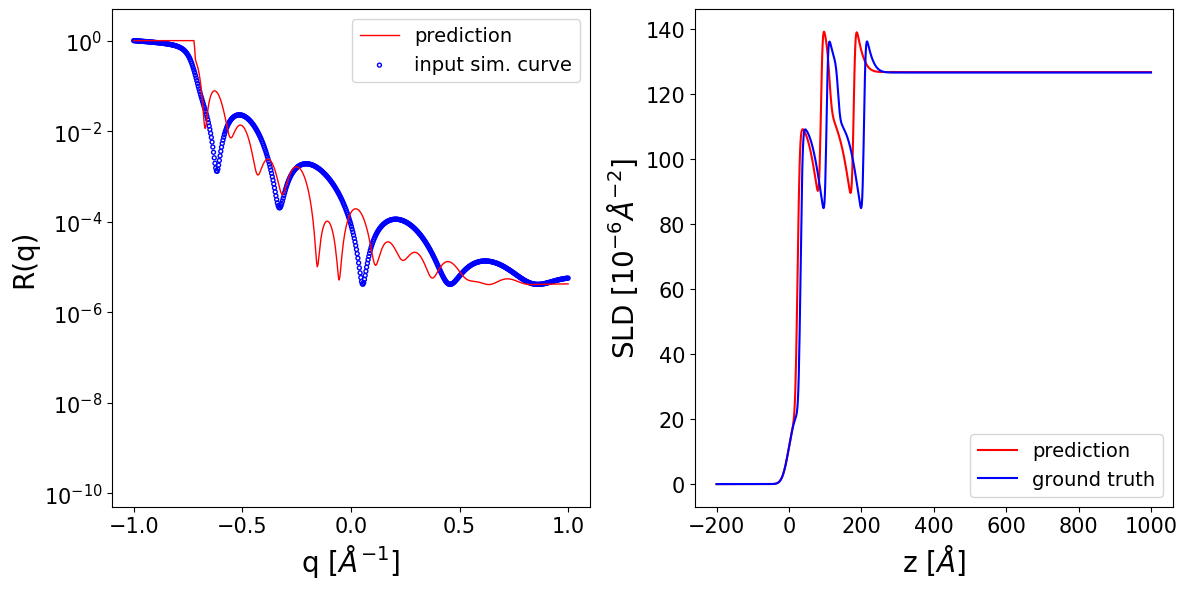

In [67]:
testing_params_cuda = torch.tensor(testing_params).to('cuda')  # move to GPU
testing_params_cuda = torch.real(testing_params_cuda)
i = 317
plot_refl_curve(testing_params_cuda,restored_predictions, i)
print("Actual thickness ", testing_params_cuda[i,:testing_num_layers])
print("Prediction thickness ", restored_predictions[i,:testing_num_layers])
print("Actual SLD ", testing_params_cuda[i,testing_num_layers*2+1:-1])
print("Prediction SLD ", restored_predictions[i,testing_num_layers*2+1:-1])
print("Actual background ", testing_params_cuda[i,-1])
print("Prediction background ", restored_predictions[i,-1])

In [69]:
pred_idx = 317
print(f'Actual thicknesses: {testing_params_cuda[pred_idx,:testing_num_layers]}')
print(f'Actual roughnesses: {testing_params_cuda[pred_idx,testing_num_layers:testing_num_layers*2+1]}')
print(f'Actual layer SLDs: {testing_params_cuda[pred_idx,testing_num_layers*2+1:-1]}')
print(f'Actual Background: {testing_params_cuda[pred_idx,-1]}')

print(f'Predicted thicknesses: {eval_thicknesses[pred_idx]}')
print(f'Predicted roughnesses: {eval_roughnesses[pred_idx]}')
print(f'Predicted layer SLDs: {eval_slds[pred_idx]}')
print(f'Predicted background: {eval_background[pred_idx]}')

def loss(pred, true):
    percentage_error = torch.abs((true - pred) / (true + 1e-8))
    return torch.mean(percentage_error) * 100

def rmsd(pred, true):
    true = torch.as_tensor(true, dtype=torch.float32,device='cuda')
    pred = torch.as_tensor(pred, dtype=torch.float32, device = 'cuda')
    rmsd = torch.sqrt(torch.mean((true - pred) ** 2))
    return (rmsd / torch.mean(torch.abs(true))) * 100


def evaluate_model(pred_thickness, true_thickness,
                   pred_roughness, true_roughness,
                   pred_sld, true_sld,
                   pred_background, true_background,
                   pred_curve,true_curve):
    loss_thickness = loss(pred_thickness, true_thickness)
    loss_roughness = loss(pred_roughness, true_roughness)
    loss_sld = loss(pred_sld, true_sld)
    loss_background = loss(pred_background, true_background)
    loss_curve = rmsd(pred_curve,true_curve)

    print(f"Thickness error: {loss_thickness:.6f}%")
    print(f"Roughness error: {loss_roughness:.6f}%")
    print(f"SLD error: {loss_sld:.6f}%")
    print(f"Background error: {loss_background:.6f}%")

    return loss_thickness, loss_roughness, loss_sld,loss_background,loss_curve

loss_t, loss_r, loss_s, loss_b,loss_curve = evaluate_model(
    eval_thicknesses[pred_idx], testing_params_cuda[pred_idx,:testing_num_layers],
    eval_roughnesses[pred_idx], testing_params_cuda[pred_idx,testing_num_layers:testing_num_layers*2+1],
    eval_slds[pred_idx], testing_params_cuda[pred_idx,testing_num_layers*2+1:-1],
    eval_background[pred_idx], testing_params_cuda[pred_idx,-1],
    predicted_curves[pred_idx],testing_curves[pred_idx]
)

total_loss = loss_t+ loss_r+ loss_s+loss_b
print(f"Total parameter error: {total_loss:.6f}% of {pred_idx} curve")

print(f"Curve {pred_idx} error: {loss_curve:.6f}%")

Actual thicknesses: tensor([32.0917, 59.6717, 11.7856, 32.0917, 59.6717, 11.7856], device='cuda:0',
       dtype=torch.float64)
Actual roughnesses: tensor([14.5388,  4.5202, 25.4979,  3.7825,  4.5202, 25.4979,  3.7825],
       device='cuda:0', dtype=torch.float64)
Actual layer SLDs: tensor([ 22.7237, 110.8399,  62.2589, 126.4736, 110.8399,  62.2589, 126.4736],
       device='cuda:0', dtype=torch.float64)
Actual Background: 4.0987761217881994e-06
Predicted thicknesses: tensor([23.8418, 58.4188,  5.8952, 24.0244, 59.9325,  6.3865], device='cuda:0')
Predicted roughnesses: tensor([14.5980,  5.0083, 25.4229,  4.0678,  5.0278, 25.4229,  4.0562],
       device='cuda:0')
Predicted layer SLDs: tensor([ 22.7598, 111.3677,  62.5331, 126.3562, 110.6863,  62.7022, 126.6160],
       device='cuda:0')
Predicted background: 4.064038876094855e-06
Thickness error: 24.862116%
Roughness error: 5.400532%
SLD error: 0.304508%
Background error: 0.845440%
Total parameter error: 31.412597% of 317 curve
Curve 31

In [72]:
loss_t, loss_r, loss_s,loss_b,loss_curve = evaluate_model(
    eval_thicknesses, testing_params_cuda[:,:testing_num_layers],
    eval_roughnesses, testing_params_cuda[:,testing_num_layers:testing_num_layers*2+1],
    eval_slds, testing_params_cuda[:,testing_num_layers*2+1:-1],
    eval_background, testing_params_cuda[:,-1],
    predicted_curves,testing_curves
)

total_loss = loss_t+ loss_r+ loss_s+loss_b
print(f"Total error of paraemters: {total_loss:.6f}% of each curve")

print(f"Total error of Curves: {loss_curve:.6f}")

Thickness error: 29.188170%
Roughness error: 54.239781%
SLD error: 0.520079%
Background error: 29.275076%
Total error of paraemters: 113.223106% of each curve
Total error of Curves: 908.217834


:::{tip}
:class: dropdown

The saved weights can be loaded into a compatible neural network (`net`) as:

```python
saved_dict = torch.load(save_path)
model_state_dict = saved_dict['model']
net.load_state_dict(model_state_dict)
```

:::

The model state dictionaries of all the saved '.pt' files in a directory can be further converted to the '.safetensors' format for exporting to Huggingface using the `convert_pt_to_safetensors` method.

### Training from the terminal

Above we described the workflow for training a model in a Jupyter Notebook, where we loaded the trainer from the configuration file but defined the callbacks manually. Alternatively, one can train a model from the terminal (in this case the callbacks defined in the configuration file are used):

```bash
python -m reflectorch.train config_name
``` 


## Customizing the YAML configuration for training

In the following we show how the YAML configuration file can be customized.

```{dropdown} Sample YAML configuration
```yaml

general:
  name: a_base_point_xray_conv_standard
  root_dir: null
  
dset:
  cls: ReflectivityDataLoader
  prior_sampler:
    cls: SubpriorParametricSampler
    kwargs:
      param_ranges:
        thicknesses: [1., 500.]
        roughnesses: [0., 60.]
        slds: [0., 50.]
      bound_width_ranges:
        thicknesses: [1.0e-2, 500.]
        roughnesses: [1.0e-2, 60.]
        slds: [1.0e-2, 5.]
      model_name: standard_model
      max_num_layers: 2
      constrained_roughness: true
      max_thickness_share: 0.5
      logdist: false
      scale_params_by_ranges: false
      scaled_range: [-1., 1.]
      device: 'cuda'
      
  q_generator:
    cls: ConstantQ
    kwargs:
      q: [0.02, 0.15, 128]
      device: 'cuda'
      
  intensity_noise:
    cls: GaussianExpIntensityNoise
    kwargs:
      relative_errors: [0.01, 0.3]
      consistent_rel_err: false
      apply_shift: true
      shift_range: [-0.3, 0.3]
      add_to_context: true

  curves_scaler:
    cls: LogAffineCurvesScaler
    kwargs:
      weight: 0.2
      bias: 1.0
      eps: 1.0e-10

model:
  network:
    cls: NetworkWithPriors
    pretrained_name: null
    device: 'cuda'
    kwargs:
      embedding_net_type: 'conv'
      embedding_net_kwargs:
        in_channels: 1
        hidden_channels: [32, 64, 128, 256, 512]
        kernel_size: 3
        dim_embedding: 128
        dim_avpool: 1
        use_batch_norm: true
        use_se: false
        activation: 'gelu'
      pretrained_embedding_net: null
      dim_out: 8
      dim_conditioning_params: 0
      layer_width: 512
      num_blocks: 8
      repeats_per_block: 2
      residual: true
      use_batch_norm: true
      use_layer_norm: false
      mlp_activation: 'gelu'
      dropout_rate: 0.0 
      conditioning: 'film'
      concat_condition_first_layer: false
       
training:
  trainer_cls: PointEstimatorTrainer
  num_iterations: 10000
  batch_size: 4096
  lr: 1.0e-3
  grad_accumulation_steps: 1
  clip_grad_norm_max: null
  update_tqdm_freq: 1
  optimizer: AdamW
  trainer_kwargs:
    train_with_q_input: false
    condition_on_q_resolutions: false
    rescale_loss_interval_width: true
    use_l1_loss: true
    optim_kwargs:
      betas: [0.9, 0.999]
      weight_decay: 0.0005
  callbacks:
    save_best_model:
      enable: true
      freq: 500
    lr_scheduler:
      cls: CosineAnnealingWithWarmup
      kwargs:
        min_lr: 1.0e-6
        warmup_iters: 500
        total_iters: 10000

  logger:
    cls: TensorBoardLogger
    kwargs:
      log_dir: "tensorboard_runs/test_1"
```

The `general` key, contains the following subkeys:

- `name` - name used for saving the model
- `root` - path to the root directory, defaults to the package directory

```yaml
general:
  name: a_base_point_xray_conv_standard
  root_dir: null
```

The `dset` key defines the settings pertaining to the data generation (i.e. the SLD profile parameterization, the ranges of the thin film parameters, the q values, the noise added to the reflectivity curves and the scaling of the reflectivity curves). It has the following subkeys:

1. `cls` (*optional*) - the class of the data loader. If not provided, the default class `ReflectivityDataLoader` is used.

2. `prior_sampler` - responsible for defining the type of SLD parameterization, the ranges from which the thin film parameters are sampled and the ranges from which the widths of the prior bounds are sampled. The `SubpriorParametricSampler` class first samples a center (**C**) from the parameter ranges and a width (**W**) from the bound width ranges. This defines a subinterval delimited by the minimum prior bound **B_min** = **C** - **W**/2 and the maximum prior bound **B_max** = **C** + **W**/2. Then, the values of the parameters (to be used for simulating the reflectivity curves and as ground truth) are uniformly sampled within the interval [**B_min**, **B_max**]. It has the following keyword arguments:
- `model_name` - name associated with the type of SLD parameterization. Here, `standard_model` represents the standard box model parameterization of the SLD with the parameters thickness, roughness and real layer SLD.
- `max_num_layers` - the number of layers in the thin film (in addition to the substrate)
- `param_ranges` - the ranges from which the values of each type of thin film parameter are uniformly sampled (for the standard model `thicknesses`, `roughnesses` and `slds`) 
- `bound_width_ranges` - the ranges from which the prior bound widths of each type of thin film parameter are uniformly sampled. If the argument `logdist` is set to `true`, the prior bound widths are sampled uniformly on a logarithmic scale instead, biasing the training towards smaller prior bound widths.
- `constrained_roughness` - if `true` the sampling of the roughness parameters is constrained such that the roughness of an interface between two layers does not exceed a fraction (defined by the argument `max_thickness_share`) of the thickness of either one of those layers.
- `max_total_thickness` (optional) - if provided, the sampling is performed such that the sum of the sampled layer thicknesses does not exceed this value
- `scale_params_by_ranges` - if `true` the parameters are scaled with respect to their ranges, otherwise they are scaled with respect to their subprior bound interval. The default is `false`.
- `scaled_range` - the ML-friendly range to which the parameters (and prior bounds) are scaled to, the default is [-1, 1]
- `device` - default is `'cuda'` for GPU use, can be changed to `'cpu'` for CPU use

```{figure} FigureReflectometryNetwork.png
:scale: 25
:align: center
:name: figure_reflectometry_network
(a) Parameter sampling process (b) Neural network architecture
```

```yaml
dset:
  cls: ReflectivityDataLoader
  prior_sampler:
    cls: SubpriorParametricSampler
    kwargs:
      param_ranges:
        thicknesses: [1., 500.]
        roughnesses: [0., 60.]
        slds: [0., 50.]
      bound_width_ranges:
        thicknesses: [1.0e-2, 500.]
        roughnesses: [1.0e-2, 60.]
        slds: [1.0e-2, 5.]
      model_name: standard_model
      max_num_layers: 2
      constrained_roughness: true
      max_thickness_share: 0.5
      logdist: false
      scale_params_by_ranges: false
      scaled_range: [-1., 1.]
      device: 'cuda'
```

3. `q_generator` - responsible for generating the transfer vector (q) values at which the reflectivity is to be simulated. We must first specifiy its class. The `ConstantQ` class generates a fixed discretization for all the reflectivity curves in the batch. Its `q` keyword argument is a tuple formatted as *[q_min, q_max, num_q_points]*, which defines the minimum q value, the maximum q value as well as the number of points (including the interval boundaries) to be equidistantly sampled. Other q generator classes are available such as `VariableQ` (equidistant grid with variable *q_min*, *q_max* and *num_q_points*, further described in the *Advanced functionality* section) and `ConstantAngle` which generates the grid of q values based on equidistantlly sampled scattering angles and the wavelength of the beam. The `device` argument can be changed to `'cpu'` for CPU use (default is `'cuda'` for GPU use).

```yaml

dset:
  q_generator:
    cls: ConstantQ
    kwargs:
      q: [0.02, 0.15, 128]
      device: 'cuda'
      
```      

4. `q_noise` (*optional*) - responsible for adding noise to the generated q values, which emulates possible measurement errors due to sample misalignment. The `BasicQNoiseGenerator` class can add both systematic q shifts (the same change applied to all q points of a curve) and random noise (different changes applied to each q point of a curve) to the q values of the batch of curves, it has the following arguments:
- `shift_std` - the standard deviation of the normal distribution for sampling the systematic q shifts (one value sampled per curve in the batch)
- `noise_std` - the standard deviation of the normal distribution for sampling the random q noise (one value sampled per point in the curve). The standard deviation is the same for all curves in the batch if provided as a float, or uniformly sampled from a range for each curve in the batch if provided as a tuple.

```yaml
dset:
  q_noise:
    cls: BasicQNoiseGenerator
    kwargs:
      shift_std: 1.0e-3
      noise_std: [0., 1.0e-3]
```

5. `intensity_noise` - responsible for adding noise to the intensity values of the reflectivity curves.

    The `GaussianExpIntensityNoise` combines three types of noise:
    - Gaussian noise: Applies Gaussian noise to account for count-based Poisson noise as well as other sources of error.
    - Shift noise: Applies a multiplicative scaling to the curves, equivalent to a vertical shift in logarithmic space.
    - Background noise: Adds a constant background to the curves.

    It has the following arguments:
    - `relative_errors` - range of relative errors for Gaussian noise.
    - `consistent_rel_err` - if `true`, uses a consistent relative error for Gaussian noise across all points in a curve.
    - `apply_shift` - if `true`, applies shift noise to the curves.
    - `shift_range` - range of shift factors for shift noise.
    - `apply_background` - if `true`, applies background noise to the curves.
    - `background_range` - range for background values.

```yaml
intensity_noise:
  cls: GaussianExpIntensityNoise
  kwargs:
    relative_errors: [0.01, 0.3]
    consistent_rel_err: false
    apply_shift: true
    shift_range: [-0.3, 0.3]
    apply_background: false
    background_range: [1.0e-10, 1.0e-4]
    add_to_context: true
```

6. `smearing` (*optional*) - responsible for adding resolution smearing to the curves (which can occur in neutron experiments due to uncertainties in incident angle  or wavelength). The intensity at a q point will be the average of the intensities of neighbouring q points, weighted by a gaussian profile. The arguments of the `Smearing` class are:
- `sigma_range` - the range for sampling the resolutions
- `constant_dq` - if `True` the smearing is constant (the resolution is given by the constant dq at each point in the curve, i.e. x-ray variant), otherwise the smearing is linear (the resolution is given by the constant dq/q at each point in the curve, i.e. neutron variant)
- `gauss_num` - the number of points used to define the Gaussian smearing kernel. A higher number increases precision at the cost of computational efficiency.
- `share_smeared` - the share of curves in the batch for which the resolution smearing is applied

```yaml
dset:   
  smearing:
    cls: Smearing
    kwargs:
      sigma_range: [0.01, 0.08]
      constant_dq: False
      gauss_num: 17
      share_smeared: 0.8
```

7. `curves_scaler` - responsible for scaling the reflectivity curves to a ML-friendly range. The `LogAffineCurvesScaler` class scales the reflectivity curves (R) accoring to the formula: 

$R_{scaled} = log_{10}(R + eps) \times weight + bias$

The argument `eps` sets the minimum intensity value of the reflectivity curves which is considered. The default values of 1.0e-10 for `eps`, 0.2 for `weight` and 1.0 for `bias` results in the interval [-1, 1] for the scaled reflectivity curves. 

```yaml
dset:    
  curves_scaler:
    cls: LogAffineCurvesScaler
    kwargs:
      weight: 0.2
      bias: 1.0
      eps: 1.0e-10
```

The `model` key defines the neural network architecture. Its `network` subkey contains the following subkeys:

- `cls` - the class of the neural network
- `pretrained_name` - the name of a pretrained model used to initialize the weights (optional)
- `device` - the Pytorch device (either `cuda` or `cpu`)
- `kwargs` - the keyword arguments for the provided class

The `NetworkWithPriors` class has the following keyword arguments:
- `embedding_net_type` - the type of embedding network (e.g. `'conv'` for a 1D CNN, `'fno'` for a FNO)
- `embedding_net_kwargs` - the keyword arguments corresponding to the chosen embedding network (e.g. for the 1D CNN: `in_channels` - the number of input channels of the 1D CNN, `hidden_channels` - list with the number of channels for each layer of the 1D CNN, `dim_embedding` - the dimension of the embedding produced by the 1D CNN, `dim_avpool` - the output size of the adaptive average pooling layer, `activation` - the type of activation function in the 1D CNN)
- `pretrained_embedding_net` - the path to the weights of a pretrained embedding network (optional)
- `dim_out` - the dimension of the output produced by the MLP (i.e. the number of thin film parameters to be predicted)
- `dim_conditioning_params` - the dimension of extra parameters used as input to the network in specific training scenarios (such as the resolution coefficient dq/q), defaults to 0.
- `layer_width` - the width (i.e. number of neurons) of a linear layer in the MLP
- `num_blocks` - the number of residual blocks in the MLP
- `repeats_per_block` - the number of normalization/activation/linear repeats in a block
- `use_batch_norm` - whether to use batch normalization in the MLP
- `use_layer_norm` - whether to use layer normalization in the MLP (if batch normalization is not used)
- `mlp_activation` - the type of activation function in the MLP
- `dropout_rate` - dropout rate for each block
- `conditioning` - the modality in which the prior bounds are provided to the network, either by concatenating the prior bounds to the data embedding ( `'concat'`) before the MLP or by modulating the intermediated features in each block of the MLP via [FiLM](https://arxiv.org/abs/1709.07871) layers (`'film'`) or [GLU](https://pytorch.org/docs/stable/generated/torch.nn.GLU.html) layers (`'glu'`). If `concat_condition_first_layer` is `true`, the concatenation is performed even when `'film'` or `'glu'` are used.


```yaml

model:
  network:
    cls: NetworkWithPriors
    pretrained_name: null
    device: 'cuda'
    kwargs:
      embedding_net_type: 'conv'
      embedding_net_kwargs:
        in_channels: 1
        hidden_channels: [32, 64, 128, 256, 512]
        kernel_size: 3
        dim_embedding: 128
        dim_avpool: 1
        use_batch_norm: true
        activation: 'gelu'
      pretrained_embedding_net: null
      dim_out: 8
      dim_conditioning_params: 0
      layer_width: 512
      num_blocks: 8
      repeats_per_block: 2
      residual: true
      use_batch_norm: true
      use_layer_norm: false
      mlp_activation: 'gelu'
      dropout_rate: 0.0 
      conditioning: 'film' # 'concat', 'glu', 'film'
      concat_condition_first_layer: false
  
```

The `training` key can be used to customize the training settings:

- `trainer_cls` - the class of the trainer (by default `PointEstimatorTrainer`)
- `num_iterations` - the total number of training iterations
- `batch_size` - the batch size (number of curves generated at each iteration)
- `lr` - the initial learning rate
- `grad_accumulation_steps` - if larger than 1, training is performed using gradient accumulation with the chosen number of steps
- `clip_grad_norm_max` - the maximum norm for gradient clipping (optional)
- `update_tqdm_freq` - the frequency for updating the [tqdm progress bar](https://tqdm.github.io/)
- `optimizer` - the used [Pytorch optimizer](https://pytorch.org/docs/stable/optim). Default is `AdamW`
- `trainer_kwargs` - additional trainer keyword arguments. Can be used to specify optional inputs to the network, such as the q values (`train_with_q_input`) or the resolution coefficient (`condition_on_q_resolutions`). Can also be used for setting the optimizer keyword arguments (`optim_kwargs`).
- `callbacks` - (optional) the callback classes together with their keyword arguments.
- `logger` - (optional) a Tensorboard logger for monitoring the progress of the training.

```yaml

training:
  trainer_cls: PointEstimatorTrainer
  num_iterations: 100000
  batch_size: 4096
  lr: 1.0e-3
  grad_accumulation_steps: 1
  clip_grad_norm_max: null
  update_tqdm_freq: 1
  optimizer: AdamW
  trainer_kwargs:
    train_with_q_input: false
    condition_on_q_resolutions: false
    rescale_loss_interval_width: true
    use_l1_loss: true
    optim_kwargs:
      betas: [0.9, 0.999]
      weight_decay: 0.0005
  callbacks:
    save_best_model:
      enable: true
      freq: 500
    lr_scheduler:
      cls: StepLR
      kwargs:
        step_size: 20000
        gamma: 0.5
  logger:
    cls: TensorBoardLogger
    kwargs:
      log_dir: "tensorboard_runs/test_1"
     
```